## Задание 1

Сотрудник службы оценки качества продукции заметил, что число бракованных листов стали в партии для стали марки A больше, чем для стали марки B. Также он обратил внимание, что при средней скорости прокатки более 4 м/с число бракованных листов больше. В соответствии с этими наблюдениями, предлагается снизить скорость прокатки и ввести дополнительные меры контроля качества для стали марки A.

Обоснуйте, что:
- Более 3 бракованных листов на партию выходит значимо чаще для стали марки А, чем для стали марки B.
- При скоростях прокатки более 4 м/с свыше 3 бракованных листов стали на партию выходит значимо чаще, чем при меньших скоростях прокатки. 

Данные, необходимые для анализа, содержатся в файле «Статистика за 2018 год». Количество листов стали в каждой партии предполагается одинаковым. 

**Импортируем библиотеки**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import matthews_corrcoef

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

- matthewsr - коэффициент корреляции Мэтьюса
- proportions_diff_confint_ind - доверительный интервал для разности долей
- proportions_diff_z_stat_ind - z-статистика для расчета p-value
- proportions_diff_z_test - p-value для проверки гипотезы о разности двух долей

In [2]:
def proportions_diff_confint_ind(count_A, len_A, count_B, len_B, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    p1 = count_A / len_A
    p2 = count_B / len_B
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len_A + p2 * (1 - p2)/ len_B)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len_A + p2 * (1 - p2)/ len_B)
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(count_A, len_A, count_B, len_B):
    p1 = count_A / len_A
    p2 = count_B / len_B 
    P = float(p1*len_A + p2*len_B) / (len_A + len_B)  
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / len_A + 1. / len_B))


def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    if alternative == 'less':
        return stats.norm.cdf(z_stat)
    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

Читаем данные

In [3]:
df = pd.read_csv('Статистика за 2018 год.csv', names=['fault_num', 'rolling_speed', 'steel_mark'])
print(df.shape)
df.head(10)

(237, 3)


,fault_num,rolling_speed,steel_mark
0,3,3.8,A
1,3,3.8,B
2,3,4.8,B
3,4,4.4,B
4,6,5.0,B
5,5,4.4,B
6,3,4.0,A
7,2,5.4,B
8,1,4.6,A
9,3,4.7,A


Создаем три дополнительные бинарные колонки:
- Больше трех бракованных листов в партии
- Скорость прокатки более 4 м/c
- Сталь марки А

In [4]:
df['fault_num_more_3'] = (df['fault_num'] > 3).map({True: 1, False: 0})
df['speed_more_4'] = (df['rolling_speed'] > 4).map({True: 1, False: 0})
df['is_A_steel_mark'] = df['steel_mark'].map({'A': 1, 'B': 0})
df

,fault_num,rolling_speed,steel_mark,fault_num_more_3,speed_more_4,is_A_steel_mark
0,3,3.8,A,0,0,1
1,3,3.8,B,0,0,0
2,3,4.8,B,0,1,0
3,4,4.4,B,1,1,0
4,6,5.0,B,1,1,0
...,...,...,...,...,...,...
232,1,4.7,A,0,1,1
233,3,3.4,A,0,0,1
234,2,5.5,A,0,1,1
235,3,5.0,B,0,1,0


Околонулевой коэффициент корреляции Мэтьюса между бинарными переменными говорит нам о том, что прямой связи между ними нет

In [5]:
print('Корреляция Мэтьюса между > 3 браками в партии и маркой стали: ', \
      matthews_corrcoef(df['fault_num_more_3'], df['is_A_steel_mark']))
print('Корреляция Мэтьюса между > 3 браками в партии и скоростью прокатки > 4: ', \
      matthews_corrcoef(df['fault_num_more_3'], df['speed_more_4']))

Корреляция Мэтьюса между > 3 браками в партии и маркой стали:  -0.067789213955027
Корреляция Мэтьюса между > 3 браками в партии и скоростью прокатки > 4:  0.014738308791024087


In [6]:
df.describe()

,fault_num,rolling_speed,fault_num_more_3,speed_more_4,is_A_steel_mark
count,237.000000,237.000000,237.000000,237.000000,237.000000
mean,3.257384,4.509705,0.409283,0.755274,0.586498
std,1.807821,0.696260,0.492742,0.430834,0.493504
min,0.000000,2.500000,0.000000,0.000000,0.000000
25%,2.000000,4.100000,0.000000,1.000000,0.000000
50%,3.000000,4.600000,0.000000,1.000000,1.000000
75%,4.000000,5.000000,1.000000,1.000000,1.000000
max,8.000000,6.500000,1.000000,1.000000,1.000000


Как видим, у марки стали А больше партий с количеством брака > 3 (логично, ведь самих объектов класса А тоже больше)

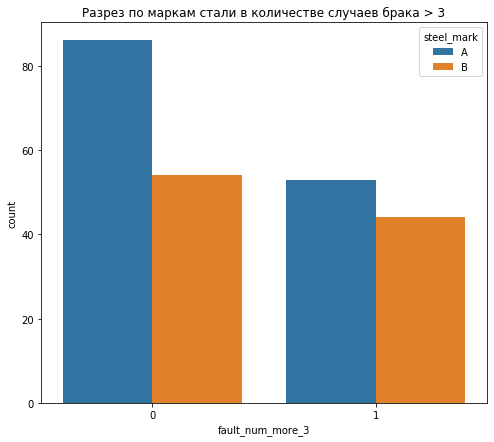

In [7]:
plt.figure(figsize=(8,7))
sns.countplot(data=df, x='fault_num_more_3', hue='steel_mark')
plt.title('Разрез по маркам стали в количестве случаев брака > 3')
plt.show()

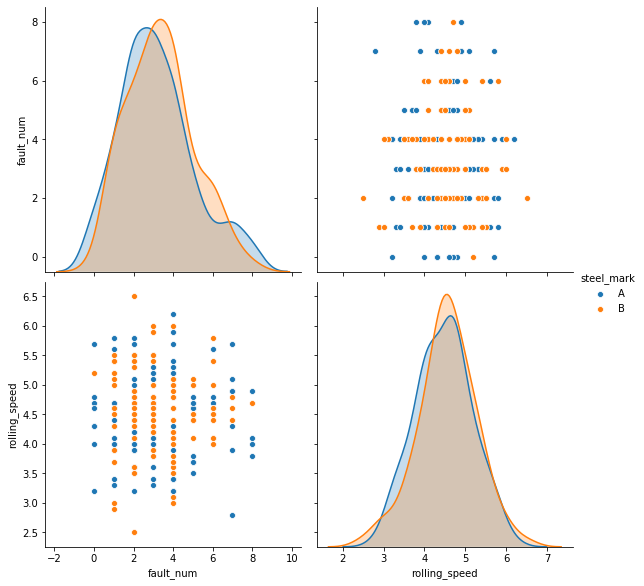

In [8]:
sns.pairplot(df[['fault_num', 'rolling_speed', 'steel_mark']], hue='steel_mark', size=4)
plt.show()

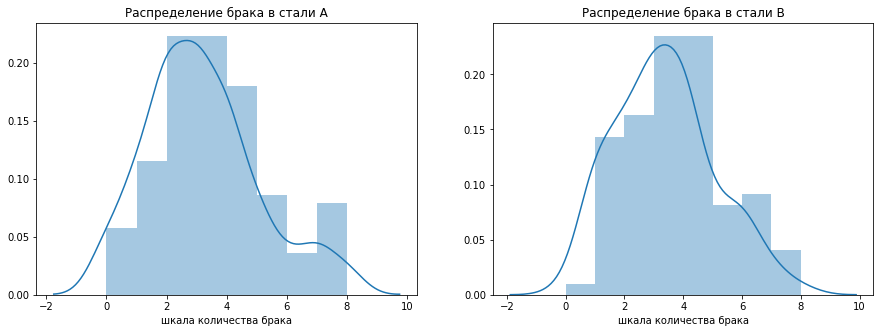

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
sns.distplot(df[df['steel_mark'] == 'A']['fault_num'], bins=8, ax=ax[0], axlabel='шкала количества брака')
sns.distplot(df[df['steel_mark'] == 'B']['fault_num'], bins=8, ax=ax[1], axlabel='шкала количества брака')
ax[0].set_title('Распределение брака в стали А')
ax[1].set_title('Распределение брака в стали B')
plt.show()

По этому графику мы можем сказать следующее: типичное количество брака ~3, типичная скорость прокатки для такого брака ~4.7

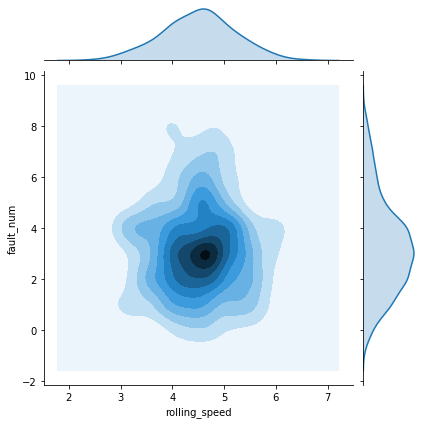

In [10]:
sns.jointplot('rolling_speed','fault_num',df, kind='kde')
plt.show()

Нормированная и НЕнормированная гистограммы распределений количества брака по маркам стали. Похоже, что в стали марки B больше случаев количества брака > 3 на партию, чем в А

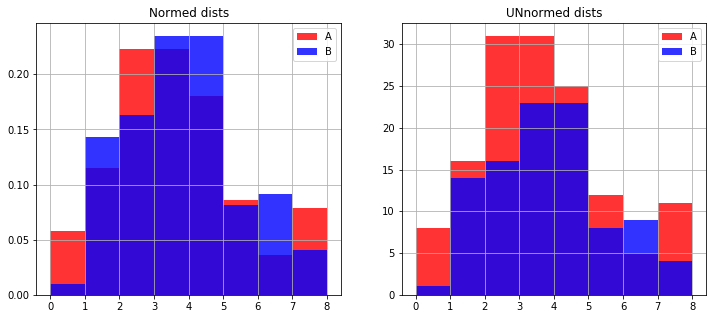

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].hist(df[df['steel_mark'] == 'A']['fault_num'], bins=8, alpha = 0.8, color= 'r', normed=True, label='A')
ax[0].hist(df[df['steel_mark'] == 'B']['fault_num'], bins=8, alpha = 0.8, color= 'b', normed=True, label='B')
ax[1].hist(df[df['steel_mark'] == 'A']['fault_num'], bins=8, alpha = 0.8, color= 'r', label='A')
ax[1].hist(df[df['steel_mark'] == 'B']['fault_num'], bins=8, alpha = 0.8, color= 'b', label='B')
ax[0].set_title('Normed dists')
ax[0].legend()
ax[0].grid()
ax[1].set_title('UNnormed dists')
ax[1].legend()
ax[1].grid()
plt.show()

Выведем несколько описательных статистик о наших данных, чтобы лучше понимать их структуру

In [12]:
print('Доля количества партий с количеством брака > 3 всей генеральной совокупности =', \
      df[df['fault_num'] > 3].shape[0] / df.shape[0])
print('Среднее количество брака генеральной совокупности =', df['fault_num'].mean())

print()

print('Количество партий стали класса А =', df[df['steel_mark'] == 'A'].shape[0])
print('Количество партий стали класса А c количеством брака > 3 =', \
      df[(df['steel_mark'] == 'A') & (df['fault_num'] > 3)].shape[0])
print('Доля количества партий с уровнем брака > 3 класса А =', \
      df[(df['steel_mark'] == 'A') & (df['fault_num'] > 3)].shape[0] / \
      df[df['steel_mark'] == 'A'].shape[0])
print('Доля количества партий с уровнем брака > 3 при скорости прокатки > 4 =', \
      df[(df['rolling_speed'] > 4.0) & (df['fault_num'] > 3)]['fault_num'].shape[0] / \
      df[df['rolling_speed'] > 4.0].shape[0])
print('Доля количества брака > 3 в общем браке стали класса A =', \
      df[(df['steel_mark'] == 'A') & (df['fault_num'] > 3)]['fault_num'].sum() / \
      df[df['steel_mark'] == 'A']['fault_num'].sum())
print('Среднее количество брака в партии стали класса А =', df[df['steel_mark'] == 'A']['fault_num'].mean())
print('Среднее количество брака > 3 в партии стали класса А =', \
      df[(df['steel_mark'] == 'A') & (df['fault_num'] > 3)]['fault_num'].mean())


print()

print('Количество партий стали класса B =', df[df['steel_mark'] == 'B'].shape[0])
print('Количество партий стали класса B c количеством брака > 3 =', \
      df[(df['steel_mark'] == 'B') & (df['fault_num'] > 3)].shape[0])
print('Доля количества партий с уровнем брака > 3 класса B =', \
      df[(df['steel_mark'] == 'B') & (df['fault_num'] > 3)].shape[0] / \
      df[df['steel_mark'] == 'B'].shape[0])
print('Доля количества партий с уровнем брака > 3 при скорости прокатки <= 4 =', \
      df[(df['rolling_speed'] <= 4.0) & (df['fault_num'] > 3)]['fault_num'].shape[0] / \
      df[df['rolling_speed'] <= 4.0].shape[0])
print('Доля количества брака > 3 в общем браке стали класса B =', \
      df[(df['steel_mark'] == 'B') & (df['fault_num'] > 3)]['fault_num'].sum() / \
      df[df['steel_mark'] == 'B']['fault_num'].sum())
print('Среднее количество брака в партии стали класса B =', df[df['steel_mark'] == 'B']['fault_num'].mean())
print('Среднее количество брака > 3 в партии стали класса B =', \
      df[(df['steel_mark'] == 'B') & (df['fault_num'] > 3)]['fault_num'].mean())


Доля количества партий с количеством брака > 3 всей генеральной совокупности = 0.4092827004219409
Среднее количество брака генеральной совокупности = 3.257383966244726

Количество партий стали класса А = 139
Количество партий стали класса А c количеством брака > 3 = 53
Доля количества партий с уровнем брака > 3 класса А = 0.381294964028777
Доля количества партий с уровнем брака > 3 при скорости прокатки > 4 = 0.4134078212290503
Доля количества брака > 3 в общем браке стали класса A = 0.6131221719457014
Среднее количество брака в партии стали класса А = 3.179856115107914
Среднее количество брака > 3 в партии стали класса А = 5.113207547169812

Количество партий стали класса B = 98
Количество партий стали класса B c количеством брака > 3 = 44
Доля количества партий с уровнем брака > 3 класса B = 0.4489795918367347
Доля количества партий с уровнем брака > 3 при скорости прокатки <= 4 = 0.39655172413793105
Доля количества брака > 3 в общем браке стали класса B = 0.6515151515151515
Среднее 

### Часть 1

Построим доверительные интервалы для долей. А то есть: в каких диапазонах может лежать вероятность того, что количество брака в партии будет > 3 (для каждой марки стали). Как видим, доверительные интервалы для долей, посчитанные из нормального распределения (как и методом Вилсона) пересекаются, поэтому сделать вывод о том, что в партиях стали класса А чаще можно увидеть количество брака > 3, чем стали класса B пока что нельзя

In [13]:
count_A = 53
len_A = 139
count_B = 44
len_B = 98

normal_interval_A = proportion_confint(count_A, len_A, method = 'normal')
normal_interval_B = proportion_confint(count_B, len_B, method = 'normal')
wilson_interval_A = proportion_confint(count_A, len_A, method = 'wilson')
wilson_interval_B = proportion_confint(count_B, len_B, method = 'wilson')

print('Steel class A partition normal interval [%f, %f] with width [%f]' % (normal_interval_A[0],
                                                  normal_interval_A[1], 
                                                  normal_interval_A[1] - normal_interval_A[0]))
print('Steel class B partition normal interval [%f, %f] with width [%f]' % (normal_interval_B[0],
                                                  normal_interval_B[1], 
                                                  normal_interval_B[1] - normal_interval_B[0]))
print()
print('Steel class A partition Wilson interval [%f, %f] with width [%f]' % (wilson_interval_A[0],
                                                  wilson_interval_A[1], 
                                                  wilson_interval_A[1] - wilson_interval_A[0]))
print('Steel class B partition Wilson interval [%f, %f] with width [%f]' % (wilson_interval_B[0],
                                                  wilson_interval_B[1], 
                                                  wilson_interval_B[1] - wilson_interval_B[0]))

Steel class A partition normal interval [0.300550, 0.462039] with width [0.161489]
Steel class B partition normal interval [0.350503, 0.547456] with width [0.196953]

Steel class A partition Wilson interval [0.304772, 0.464203] with width [0.159431]
Steel class B partition Wilson interval [0.354284, 0.547525] with width [0.193241]


Построим доверительный интервал для разности долей. Видим, что 0 входит в него, поэтому однозначно сказать что-то по поводу разницы в частоте попадания количества брака > 3 в партию стали в разрезе классов мы пока что не можем. Но видим большее смещение влево. Отюсда, наоборот, можно сделать предположение, что в марке стали А брака как раз таки в среднем меньше

In [14]:
print('95%% confidence interval for a difference of class A and class B: [%.4f, %.4f]' %
      proportions_diff_confint_ind(count_A, len_A, count_B, len_B))

95% confidence interval for a difference of class A and class B: [-0.1950, 0.0597]


На уровне значимости 0.15 можно опровергнуть гипотезу о том, что в марке стали А частота появления партий с количеством брака > 3 такая же, как у стали марки B, в пользу левосторонней альтернативы, что в марке стали А данного вида брака меньше, чем в марке стали B.

In [15]:
print("A diff B p-value for two-sided: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(count_A, len_A, count_B, len_B)))
print("A less B p-value for less: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(count_A, len_A, count_B, len_B), 'less'))
print("A greater B p-value for greater: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(count_A, len_A, count_B, len_B), 'greater'))

A diff B p-value for two-sided: 0.296670
A less B p-value for less: 0.148335
A greater B p-value for greater: 0.851665


### Часть 2

По нормированному графику совершенно невозможно понять, влияет ли как-то скорость прокатки > 4 м/с на количество брака > 3 в партиях стали

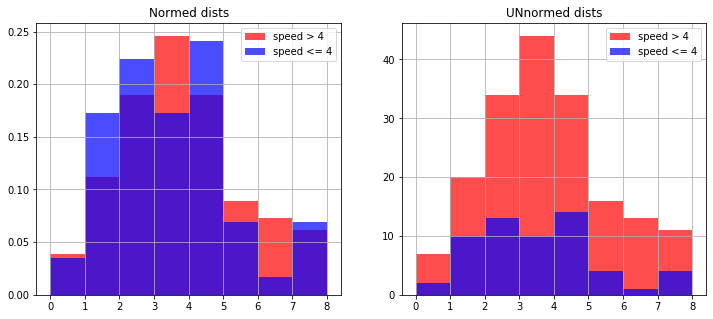

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].hist(df[df['rolling_speed'] > 4]['fault_num'], \
           bins=8, alpha = 0.7, color= 'r', normed=True, label='speed > 4')
ax[0].hist(df[df['rolling_speed'] <= 4]['fault_num'], \
           bins=8, alpha = 0.7, color= 'b', normed=True, label='speed <= 4')
ax[1].hist(df[df['rolling_speed'] > 4]['fault_num'], \
           bins=8, alpha = 0.7, color= 'r', label='speed > 4')
ax[1].hist(df[df['rolling_speed'] <= 4]['fault_num'], \
           bins=8, alpha = 0.7, color= 'b', label='speed <= 4')
ax[0].set_title('Normed dists')
ax[0].legend()
ax[0].grid()
ax[1].set_title('UNnormed dists')
ax[1].legend()
ax[1].grid()
plt.show()

Построим доверительные интервалы для долей. А то есть: в каких диапазонах может лежать вероятность того, что количество брака в партии будет > 3 при прокатке со скоростью выше/ниже 4 м/c. Как видим, доверительные интервалы получились мало того, что широкие, так еще пересекающиеся в большом интервале

In [17]:
count_speed_more_4 = 74
len_speed_more_4 = 179
count_speed_less_4 = 23
len_speed_less_4 = 58

# count_speed_more_4, len_speed_more_4, count_speed_less_4, len_speed_less_4

normal_interval_A = proportion_confint(count_speed_more_4, len_speed_more_4, method = 'normal')
normal_interval_B = proportion_confint(count_speed_less_4, len_speed_less_4, method = 'normal')
wilson_interval_A = proportion_confint(count_speed_more_4, len_speed_more_4, method = 'wilson')
wilson_interval_B = proportion_confint(count_speed_less_4, len_speed_less_4, method = 'wilson')

print('Speed > 4 partition normal interval [%f, %f] with width [%f]' % (normal_interval_A[0],
                                                  normal_interval_A[1], 
                                                  normal_interval_A[1] - normal_interval_A[0]))
print('Speed <= 4 partition normal interval [%f, %f] with width [%f]' % (normal_interval_B[0],
                                                  normal_interval_B[1], 
                                                  normal_interval_B[1] - normal_interval_B[0]))
print()
print('Speed > 4 partition wilson interval [%f, %f] with width [%f]' % (wilson_interval_A[0],
                                                  wilson_interval_A[1], 
                                                  wilson_interval_A[1] - wilson_interval_A[0]))
print('Speed <= 4 partition wilson interval [%f, %f] with width [%f]' % (wilson_interval_B[0],
                                                  wilson_interval_B[1], 
                                                  wilson_interval_B[1] - wilson_interval_B[0]))

Speed > 4 partition normal interval [0.341267, 0.485548] with width [0.144281]
Speed <= 4 partition normal interval [0.270658, 0.522445] with width [0.251787]

Speed > 4 partition wilson interval [0.343825, 0.486629] with width [0.142804]
Speed <= 4 partition wilson interval [0.280888, 0.525068] with width [0.244180]


Построим доверительный интервал для разности долей. Ноль входит в него, более того, он получился даже практически симметричным около него

In [18]:
print('95%% confidence interval for a difference of speed > 4 and speed <= 4: [%.4f, %.4f]' %
      proportions_diff_confint_ind(count_speed_more_4, len_speed_more_4, count_speed_less_4, len_speed_less_4))

95% confidence interval for a difference of speed > 4 and speed <= 4: [-0.1282, 0.1620]


p-value получился большим с какой стороны ни подойди. О чем это нам говорит:
- во-первых, опровергнуть гипотезу о разности двух долей мы не можем
- во-вторых, подтвердить гипотезу о влиянии скорости проката стали на количество брака > 3 в партии мы тоже не можем
- в-третьих, скорее всего скорость прокатки незначимо влияет на количество брака > 3 в партии, но! Однозначный вывод сделать можно было бы при больших размерах выборки. Тех данных, которые у нас есть, недостаточно

In [19]:
print("p-value for two-sided: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(count_speed_more_4, len_speed_more_4, count_speed_less_4, len_speed_less_4)))
print("p-value for less: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(count_speed_more_4, len_speed_more_4, count_speed_less_4, len_speed_less_4), 'less'))
print("p-value for greater: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(count_speed_more_4, len_speed_more_4, count_speed_less_4, len_speed_less_4), 'greater'))

p-value for two-sided: 0.820507
p-value for less: 0.589747
p-value for greater: 0.410253


## Спасибо за внимание!